In [1]:
#Download installs
import seaborn as sns
import matplotlib.pyplot as plt
!pip install pandas
!pip install numpy
import pandas as pd
import numpy as np


In [2]:
#Import dataset

transactions = pd.read_csv('transactions.csv', parse_dates = (['date']))
calendar = pd.read_csv('calendar.csv', parse_dates=(['date']))
products = pd.read_csv('products.csv')

#Merge datasets

df = transactions.merge(calendar, on='date', how='left')
df = df.merge(products, on = 'product_id', how = 'left')

In [3]:

#Create a revenue column 
df = df.assign(revenue = df['price'] * df['quantity'])

#Daily revenue
daily_revenue  = (
    df.groupby('date')['revenue']
    .sum()
    .reset_index()
    .sort_values('date')

    )

daily_revenue.head()

,date,revenue
0,2025-01-01,35.0
1,2025-01-02,67.5
2,2025-01-03,50.0
3,2025-01-04,52.0
4,2025-01-05,42.5


In [4]:
#Find top 5 products by revenue 

top_5_products = (
    df.groupby('product_name')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue')
    )

top_5_products.head()

,product_name,revenue
4,Widget E,32.0
3,Widget D,40.0
1,Widget B,45.0
2,Widget C,60.0
0,Widget A,70.0


In [5]:
#Categorize products by revenue

category_summary = (
    df.groupby('category')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue', ascending= False)     
)

category_summary

,category,revenue
2,Tools,115.0
1,Gadgets,100.0
0,Accessories,32.0


In [6]:
#Revenue based on day of the week

weekly_revenue = (
    df.groupby('day_of_week')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue')
)
weekly_revenue.head()

,day_of_week,revenue
4,Wednesday,35.0
2,Sunday,42.5
0,Friday,50.0
1,Saturday,52.0
3,Thursday,67.5


In [7]:
#weekly_revenue 

iso = df['date'].dt.isocalendar()
df = df.assign(year = iso.year.astype(int), week = iso.week.astype(int))

weekly_revenue = (
    df.groupby(['year', 'week'], as_index=False)['revenue']
    .sum()
    .reset_index()
    .sort_values(['year', 'week'])    
)

weekly_revenue



,index,year,week,revenue
0,0,2025,1,247.0


In [8]:
#YoY change in revenue

prev = weekly_revenue.rename(columns={"revenue": "revenue_prev"}).copy()
prev["year"] = prev["year"] + 1

yoy = weekly_revenue.merge(prev, on=["year","week"], how="left")
yoy["yoy_pct"] = (yoy["revenue"] - yoy["revenue_prev"]) / yoy["revenue_prev"]

yoy.head(10)


,index_x,year,week,revenue,index_y,revenue_prev,yoy_pct
0,0,2025,1,247.0,NaN,NaN,NaN


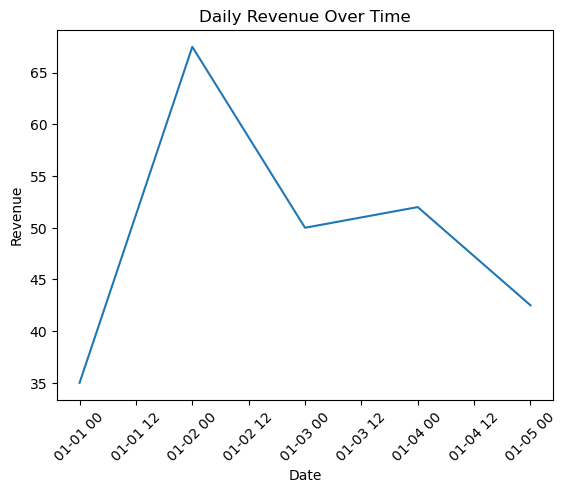

In [9]:
#Daily Revenue Visualization
plt.plot(daily_revenue['date'], daily_revenue['revenue'])
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()



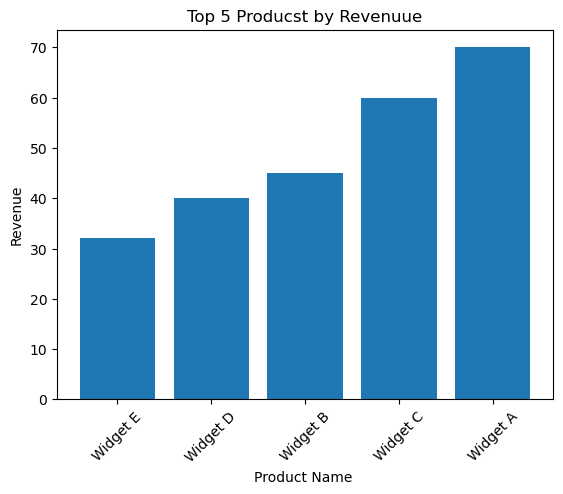

In [10]:
#Top 5 products Visualization
plt.bar(top_5_products['product_name'], top_5_products['revenue'])
plt.title('Top 5 Producst by Revenuue')
plt.xlabel('Product Name ')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

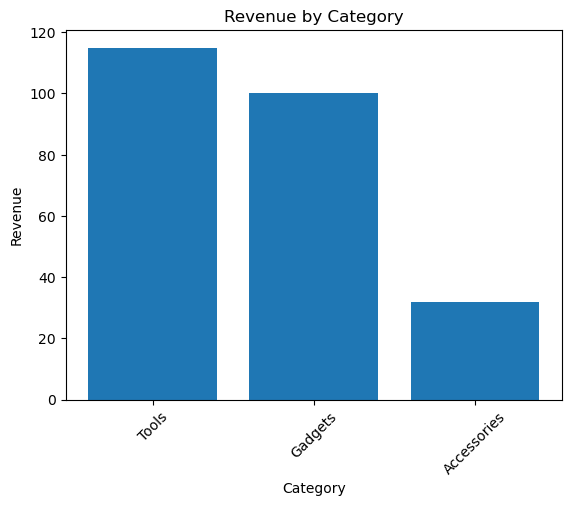

In [11]:
#Revenue by Category Visualization
plt.bar(category_summary['category'], category_summary['revenue'])
plt.title('Revenue by Category')
plt.xlabel('Category')  
plt.ylabel('Revenue')
plt.xticks(rotation=45)     
plt.show()

In [12]:
#Descriptive statistics

desc = df[['quantity', 'price', 'revenue']].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
quantity,10.0,2.4,1.349897,1.0,1.25,2.00,3.0,5.0
price,10.0,12.3,4.871687,7.5,8.50,10.00,15.0,20.0
revenue,10.0,24.7,7.153865,15.0,20.00,21.25,30.0,37.5


In [13]:
# Confidence level around mean 

rng = np.random.default_rng(42) # Random number generator
rev = df['revenue'].to_numpy() #Create numpy array 

#Number of boostrap examples 
b = 5000
boots = []
n = len(rev) #sample size

for _ in range (b):
    sample = rng.choice(rev, size = n, replace = True)
    boots.append(sample.mean())


ci_low, ci_high = np.percentile(boots,[2.5, 97.5 ])


#print results 
rev_mean = df['revenue'].mean()
rev_mean, ci_low, ci_high

(24.7, 20.7, 29.0)

In [14]:
#Standard error test 

#Normal distrubtion 
p_hat = df['is_holiday'].mean()
n = len(df) #Sample size 


#Standard error 
se = p_hat *(1- p_hat)/n
low, hi = p_hat - 1.96*se, p_hat + 1.96*se # z-score

#results
print('low',low)
print('hi',hi)
print('p_hat', p_hat)


low 0.16864
hi 0.23136
p_hat 0.2


In [15]:

#Two way proportion z-test

import math 

n_a, conv_a = 1000, 120 # 12% conversion rate 
n_b, conv_b = 980, 150 # 13.51% conversion rate 

pA = conv_a / n_a 
pB = conv_b / n_b 

# pool proportion 
p_pool = (conv_a + conv_b) / (n_a + n_b )

#two way proportion]
se = math.sqrt(p_pool * (1 - p_pool) *(1/n_a + 1/n_b))
z = (pB - pA) / se # z test 

def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

p_value = 2 * (1 - norm_cdf(abs(z)))

{'pA':pA, 'pB':pB, "z":z, 'p_value':p_value}


{'pA': 0.12,
 'pB': 0.15306122448979592,
 'z': 2.143308223199548,
 'p_value': 0.03208835696622736}

In [16]:
# Pearson correlation 
corr = df[['price', 'revenue']].corr()
print("Pearson correlation of price and revenue:", corr)

Pearson correlation of price and revenue:             price   revenue
price    1.000000 -0.500857
revenue -0.500857  1.000000


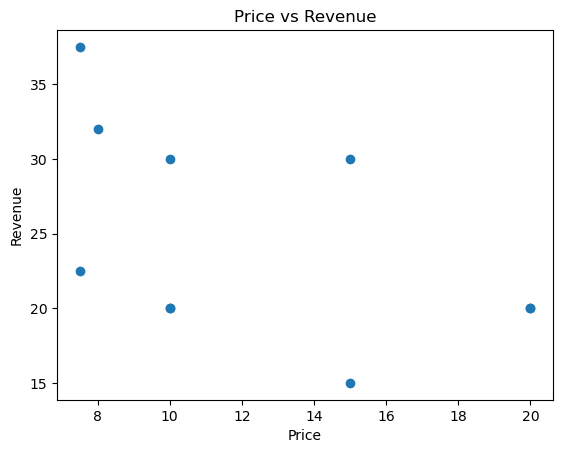

In [17]:
plt.scatter(df['price'], df['revenue'])
plt.title('Price vs Revenue')
plt.xlabel('Price')
plt.ylabel('Revenue')
plt.show()

In [18]:
# spearman reduces sensitivity to outliers. If pearson and spearman disagree your relationship may be nonlinear

spearman = df[['price', 'revenue']].corr(method = 'spearman')

print('Spearman corelation for price and revenue', spearman)

Spearman corelation for price and revenue             price   revenue
price    1.000000 -0.625051
revenue -0.625051  1.000000


In [ ]:
#partial corr

df3 = df[['price', 'revenue', 'quantity']].dropna()

# Create the function 
def residualize(y,x):
    x = np.column_stack(np.ones(len(x))) # Design Matrix 
    beta, *_ = np.linalg.lstsq(x, y, rcond = None) # Coefficents for Intercept and Slope
    y_yhat = x @ beta
    return y - y_yhat

rev_resid = residualize(df3['revenue'].to_numpy(),  df3['quantity'].to_numpy())
price_resid = residualize(df3['price'].to_numpy(),    df3['quantity'].to_numpy())

# Correlation of residuals = partial correlation (linear control)
partial_corr = np.corrcoef(price_resid, rev_resid)[0, 1]
print("Partial corr(price, revenue | quantity):", partial_corr)

LinAlgError: Incompatible dimensions

In [32]:
# Simpson Paradox correlation

out = [] # Create list object
for cat, sub in df.groupby('category'):
    sub2 = sub[['price', 'revenue']].dropna() # drop any nan values 
    if len(sub2) >=3: # Length of rows 
        c = sub2.corr().loc['price', 'revenue'] # Find correlation between the two features 
        out.append((cat, c, len(sub2))) # Add it to the list

#Print Results
for cat, c, n in out:
    print(f'category = {cat:12s} corr = {c:.3f} n = {n}')


category = Gadgets      corr = -0.686 n = 4
category = Tools        corr = -0.068 n = 5


In [21]:
#Import standardization 
from sklearn.preprocessing import StandardScaler

# Standardize the data 
scaler = StandardScaler()
scaled_data = df[['price', 'revenue', 'quantity']]

#Fit to transform 
scaled_array = scaler.fit_transform(scaled_data)

#Import into dataframe 
df = df.assign(
    price_std = scaled_array[:,0],
    revenue_std = scaled_array[:,1],
    quantity_std = scaled_array[:,2]
)

df

,transaction_id,product_id,quantity,price,date,day_of_week,is_holiday,product_name,category,revenue,year,week,price_std,revenue_std,quantity_std
0,1,101,2,10.0,2025-01-01,Wednesday,False,Widget A,Tools,20.0,2025,1,-0.497654,-0.692526,-0.312348
1,2,102,1,15.0,2025-01-01,Wednesday,False,Widget B,Tools,15.0,2025,1,0.584202,-1.429255,-1.093216
2,3,101,3,10.0,2025-01-02,Thursday,False,Widget A,Tools,30.0,2025,1,-0.497654,0.780933,0.468521
3,4,103,5,7.5,2025-01-02,Thursday,False,Widget C,Gadgets,37.5,2025,1,-1.038582,1.886027,2.030259
4,5,102,2,15.0,2025-01-03,Friday,False,Widget B,Tools,30.0,2025,1,0.584202,0.780933,-0.312348
5,6,104,1,20.0,2025-01-03,Friday,False,Widget D,Gadgets,20.0,2025,1,1.666058,-0.692526,-1.093216
6,7,105,4,8.0,2025-01-04,Saturday,True,Widget E,Accessories,32.0,2025,1,-0.930396,1.075625,1.249390
7,8,101,2,10.0,2025-01-04,Saturday,True,Widget A,Tools,20.0,2025,1,-0.497654,-0.692526,-0.312348
8,9,103,3,7.5,2025-01-05,Sunday,False,Widget C,Gadgets,22.5,2025,1,-1.038582,-0.324161,0.468521
9,10,104,1,20.0,2025-01-05,Sunday,False,Widget D,Gadgets,20.0,2025,1,1.666058,-0.692526,-1.093216


In [ ]:
#Transform category into 0's and 1's 

encoded = pd.get_dummies(df['category'], prefix ='cat')
encoded.head()


,transaction_id,product_id,quantity,price,date,day_of_week,is_holiday,product_name,category,revenue,year,week,price_std,revenue_std,quantity_std,cat_Accessories,cat_Gadgets,cat_Tools
0,1,101,2,10.0,2025-01-01,Wednesday,False,Widget A,Tools,20.0,2025,1,-0.497654,-0.692526,-0.312348,False,False,True
1,2,102,1,15.0,2025-01-01,Wednesday,False,Widget B,Tools,15.0,2025,1,0.584202,-1.429255,-1.093216,False,False,True
2,3,101,3,10.0,2025-01-02,Thursday,False,Widget A,Tools,30.0,2025,1,-0.497654,0.780933,0.468521,False,False,True
3,4,103,5,7.5,2025-01-02,Thursday,False,Widget C,Gadgets,37.5,2025,1,-1.038582,1.886027,2.030259,False,True,False
4,5,102,2,15.0,2025-01-03,Friday,False,Widget B,Tools,30.0,2025,1,0.584202,0.780933,-0.312348,False,False,True
5,6,104,1,20.0,2025-01-03,Friday,False,Widget D,Gadgets,20.0,2025,1,1.666058,-0.692526,-1.093216,False,True,False
6,7,105,4,8.0,2025-01-04,Saturday,True,Widget E,Accessories,32.0,2025,1,-0.930396,1.075625,1.249390,True,False,False
7,8,101,2,10.0,2025-01-04,Saturday,True,Widget A,Tools,20.0,2025,1,-0.497654,-0.692526,-0.312348,False,False,True
8,9,103,3,7.5,2025-01-05,Sunday,False,Widget C,Gadgets,22.5,2025,1,-1.038582,-0.324161,0.468521,False,True,False
9,10,104,1,20.0,2025-01-05,Sunday,False,Widget D,Gadgets,20.0,2025,1,1.666058,-0.692526,-1.093216,False,True,False
